In [1]:
import pandas as pd
import fuzzywuzzy 
from fuzzywuzzy import fuzz
import numpy as np
from numpy import save
import collections

/home/ig5eq/.local/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Creating FDA Matrix Function inputs

In [2]:
#This simply reads in the fda csv, we're reading in the cleaned fda look at cleanFDA for more details on cleaining
fda = pd.read_csv('../data/working/fda_clean.csv')

In [3]:
#This drops the rows that have no company name due to aggressive cleaning 
#dropped 686: PHARM ASSOC and 898: US PHARM HOLDINGS, bc all of these substrings were part of removing words list
fda_clean = fda.dropna()

In [4]:
#Reset the index of the new dataframe, post drop, to reflect the new number of rows
fda_org = fda_clean['FDA Companies '].reset_index()

In [54]:
fda_org

,index,FDA Companies
0,0,3D IMAGING DRUG
1,1,3M
2,2,3M DRUG DELIVERY
3,3,AAIPHARMA LLC
4,4,ABBOTT LABS
...,...,...
968,970,ZO SKIN HEALTH
969,971,ZYDUS HLTHCARE
970,972,ZYDUS PHARMS USA
971,973,ZYDUS PHARMS USA INC


In [5]:
fda_row = fda_org['index']

In [6]:
#subset the original company names to use as input matching function later
fda_comp = fda_org['FDA Companies ']

In [7]:
#subset the clean company names to use as input in matching function later
fda_list = fda_clean['Company Clean']

### FDA Fuzzy matching using fuzzy wuzzy

In [8]:
##Function that takes in 3 lists, the list of strings you want to compare, the list of strings you're comparing to and a list with the original way the string from list 1 was written.  
def matchWithFuzzyNames(l1, l2, original, row_num):
    match = pd.DataFrame(columns = ['original company names', 'clean company name', 'company matches', 'fuzz ratio'])
    for i in l1:
        matches = []
        score = []
        score_partial = []
        for j in l2:
            #due to time constraints, we set the fuzz.ratio to 100, however future programming should adjust this value to some other quantity to see if we get better matches
            if (fuzz.ratio(i,j)) == 100:
                matches.append(j)
                score.append(fuzz.ratio(i,j))
                #the partial ratio will return the ratio raw score of 100  if the shorter string is found an any of substrings of the larger string, used this as a safety net and potentially as an additional step to 
                score_partial.append((fuzz.partial_ratio(i,j)))
        match = match.append({ 'clean company name': i,'company matches': matches, 'fuzz ratio': score, 'fuzz partial ratio': score_partial},ignore_index=True)
        
    match['original company names'] = original
    match['original row number'] = row_num
 
#Will output a pandas dataframe with 4 columns
    return match


In [9]:
#saves the results of the fuzzy matching as a variable 
matching = matchWithFuzzyNames(fda_list,fda_list,fda_comp, fda_row)

In [25]:
for i in matching.iterrows():
    print(i)

(0, company name            d imaging drug
company matches       [d imaging drug]
fuzz ratio                       [100]
fuzz partial ratio               [100]
Name: 0, dtype: object)
(1, company name              m
company matches         [m]
fuzz ratio            [100]
fuzz partial ratio    [100]
Name: 1, dtype: object)
(2, company name            m drug delivery
company matches       [m drug delivery]
fuzz ratio                        [100]
fuzz partial ratio                [100]
Name: 2, dtype: object)
(3, company name            aaipharma
company matches       [aaipharma]
fuzz ratio                  [100]
fuzz partial ratio          [100]
Name: 3, dtype: object)
(4, company name            abbott
company matches       [abbott]
fuzz ratio               [100]
fuzz partial ratio       [100]
Name: 4, dtype: object)
(5, company name                    abbvie
company matches       [abbvie, abbvie]
fuzz ratio                  [100, 100]
fuzz partial ratio          [100, 100]
Name: 5, dty

In [33]:

matching['company matches'] = matching['company matches'].astype(str)
matching['original row number'] = matching['original row number'].astype(str)
matching['fuzz ratio'] = matching['fuzz ratio'].astype(str)

In [25]:
matching[0:10]

,original company names,clean company name,company matches,fuzz ratio,fuzz partial ratio,original row number
0,3D IMAGING DRUG,d imaging drug,['d imaging drug'],[100],[100],0
1,3M,m,['m'],[100],[100],1
2,3M DRUG DELIVERY,m drug delivery,['m drug delivery'],[100],[100],2
3,AAIPHARMA LLC,aaipharma,['aaipharma'],[100],[100],3
4,ABBOTT LABS,abbott,['abbott'],[100],[100],4
5,ABBVIE,abbvie,"['abbvie', 'abbvie']","[100, 100]","[100, 100]",5
6,ABBVIE ENDOCRINE,abbvie endocrine,"['abbvie endocrine', 'abbvie endocrine']","[100, 100]","[100, 100]",6
7,ABBVIE ENDOCRINE INC,abbvie endocrine,"['abbvie endocrine', 'abbvie endocrine']","[100, 100]","[100, 100]",7
8,ABBVIE INC,abbvie,"['abbvie', 'abbvie']","[100, 100]","[100, 100]",8
9,ABHAI INC,abhai,"['abhai', 'abhai']","[100, 100]","[100, 100]",9


### Creating truncated version of matching

In [34]:
#group by clean company name, append the original company names to list 
unique_comp = matching.groupby('clean company name', as_index = False).agg({'original company names': ', '.join, 
                                                                            'original row number': ', '.join,
                                                                            'company matches': ', '.join,
                                                                           'fuzz ratio': ', '.join} )

In [35]:
unique_comp

,clean company name,original company names,original row number,company matches,fuzz ratio
0,aaipharma,AAIPHARMA LLC,3,['aaipharma'],[100]
1,abbott,ABBOTT LABS,4,['abbott'],[100]
2,abbvie,"ABBVIE, ABBVIE INC","5, 8","['abbvie', 'abbvie'], ['abbvie', 'abbvie']","[100, 100], [100, 100]"
3,abbvie endocrine,"ABBVIE ENDOCRINE, ABBVIE ENDOCRINE INC","6, 7","['abbvie endocrine', 'abbvie endocrine'], ['ab...","[100, 100], [100, 100]"
4,abhai,"ABHAI INC, ABHAI LLC","9, 10","['abhai', 'abhai'], ['abhai', 'abhai']","[100, 100], [100, 100]"
...,...,...,...,...,...
791,zambon,ZAMBON SPA,968,['zambon'],[100]
792,zevacor,ZEVACOR PHARMA INC,969,['zevacor'],[100]
793,zo skin,ZO SKIN HEALTH,970,['zo skin'],[100]
794,zydus,"ZYDUS HLTHCARE, ZYDUS PHARMS USA, ZYDUS PHARMS...","971, 972, 973","['zydus', 'zydus', 'zydus'], ['zydus', 'zydus'...","[100, 100, 100], [100, 100, 100], [100, 100, 100]"


### Producing and attemping to analyse FDA matrix 

In [41]:
def matrix_score(l1, l2, file_path):
    #creates a matrix of zeros with the dimensions specified from the parameters
    #So if you had a list that had 5 elements in it, your matrix would be a 5x5 matrix; nrows would be 5 and ncols would be 5
    matrix = np.zeros(shape = (len(l1), len(l2)))
   
    #initialize row and col values to 0
    row = 0
    col = 0
   
    for i in l1:
        if row % (len(l1)//10) == 0:
             print("progress: %.2f" % (100*row/len(l1)) + "%")
        for j in l2:
            score = fuzz.ratio(i,j)
            matrix[row][col] = score
            col+=1
        col = 0
        row+=1
        
        
        

    save(file_path, matrix)
        
    return matrix

In [48]:
fda_matrix = matrix_score(fda_list,fda_list)

progress: 0.00%
progress: 9.97%
progress: 19.94%
progress: 29.91%
progress: 39.88%
progress: 49.85%
progress: 59.82%
progress: 69.78%
progress: 79.75%
progress: 89.72%
progress: 99.69%


In [49]:
fda_matrix

array([[100.,  13.,  41., ...,  21.,  21.,  28.],
       [ 13., 100.,  12., ...,   0.,   0.,   0.],
       [ 41.,  12., 100., ...,  20.,  20.,  27.],
       ...,
       [ 21.,   0.,  10., ..., 100., 100.,  50.],
       [ 21.,   0.,  10., ..., 100., 100.,  50.],
       [ 14.,   0.,  33., ...,  50.,  50., 100.]])

#### Looking at the frequency of the matrix numbers

In [50]:
#This gets the upper diagonal, but including the diagonal k, in our case all the 100. 
fda_upper = np.triu(fda_matrix)

In [58]:
#This gets the upper diagonal, excluding the diagonal, so it does not include all the self-matches
fda_only_upper = fda_matrix[np.triu_indices(len(fda_list), k = 1)]

In [76]:
fda_only_upper

array([ 13.,  41.,  26., ..., 100.,  50.,  50.])

In [61]:
counts = collections.Counter(fda_only_upper)

In [101]:
counts

Counter({13.0: 12944,
         41.0: 558,
         26.0: 8147,
         10.0: 11148,
         20.0: 21648,
         11.0: 14165,
         25.0: 20107,
         19.0: 11686,
         12.0: 18385,
         28.0: 2301,
         33.0: 17959,
         24.0: 16112,
         8.0: 5412,
         17.0: 28874,
         18.0: 23075,
         14.0: 17104,
         21.0: 14772,
         30.0: 9258,
         29.0: 23060,
         40.0: 10296,
         23.0: 4682,
         22.0: 19386,
         9.0: 7588,
         27.0: 19662,
         48.0: 721,
         32.0: 9255,
         16.0: 5037,
         42.0: 2295,
         36.0: 10149,
         15.0: 21638,
         35.0: 7406,
         45.0: 724,
         0.0: 29451,
         43.0: 4277,
         31.0: 14242,
         7.0: 2069,
         38.0: 7507,
         47.0: 1026,
         34.0: 1438,
         37.0: 1164,
         55.0: 1064,
         53.0: 873,
         5.0: 191,
         50.0: 3418,
         6.0: 568,
         39.0: 542,
         82.0: 24,
       

In [72]:
import operator 

In [77]:
sorted_counts = sorted(counts.items(), key=lambda x: x[1])

In [80]:
sorted_counts = sorted(counts.items())

In [81]:
sorted_counts

[(0.0, 29451),
 (4.0, 13),
 (5.0, 191),
 (6.0, 568),
 (7.0, 2069),
 (8.0, 5412),
 (9.0, 7588),
 (10.0, 11148),
 (11.0, 14165),
 (12.0, 18385),
 (13.0, 12944),
 (14.0, 17104),
 (15.0, 21638),
 (16.0, 5037),
 (17.0, 28874),
 (18.0, 23075),
 (19.0, 11686),
 (20.0, 21648),
 (21.0, 14772),
 (22.0, 19386),
 (23.0, 4682),
 (24.0, 16112),
 (25.0, 20107),
 (26.0, 8147),
 (27.0, 19662),
 (28.0, 2301),
 (29.0, 23060),
 (30.0, 9258),
 (31.0, 14242),
 (32.0, 9255),
 (33.0, 17959),
 (34.0, 1438),
 (35.0, 7406),
 (36.0, 10149),
 (37.0, 1164),
 (38.0, 7507),
 (39.0, 542),
 (40.0, 10296),
 (41.0, 558),
 (42.0, 2295),
 (43.0, 4277),
 (44.0, 2821),
 (45.0, 724),
 (46.0, 3054),
 (47.0, 1026),
 (48.0, 721),
 (49.0, 13),
 (50.0, 3418),
 (51.0, 17),
 (52.0, 228),
 (53.0, 873),
 (54.0, 91),
 (55.0, 1064),
 (56.0, 211),
 (57.0, 684),
 (58.0, 59),
 (59.0, 139),
 (60.0, 386),
 (61.0, 52),
 (62.0, 421),
 (63.0, 42),
 (64.0, 79),
 (65.0, 25),
 (67.0, 426),
 (68.0, 2),
 (69.0, 39),
 (70.0, 32),
 (71.0, 100),
 (72.0

In [86]:
from matplotlib import pyplot as plt

In [98]:
x_axis = list(counts.keys())
y_axis = list(counts.values())

<BarContainer object of 92 artists>

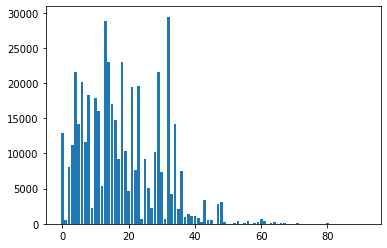

In [100]:
plt.bar(range(len(counts)),y_axis) #tick_label=x_axis)

<BarContainer object of 92 artists>

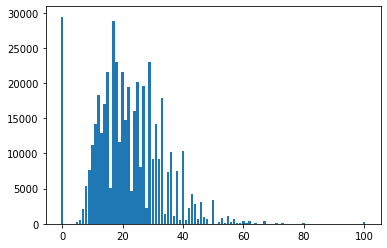

In [94]:
#this bar plot shows the frequency of the 
plt.bar(*zip(*counts.items()))

In [60]:
len(fda_only_upper)

472878

###  DNA matrix

In [3]:
#reading in dna dataset
dna = pd.read_csv('../data/working/dna_clean.csv')

In [4]:
#dropping na values due to aggressive cleaing
#which row number and companies were dropped?
dna.dropna(inplace = True) 


In [5]:
#convert column to list to pass into function
dna = dna['cleaned_companies'].tolist()

In [6]:
dna_set1 = dna[42636:53295]

In [13]:
dna_set2 = dna[53295:63954]

In [17]:
#this calcultes the fuzzy ratio of the last portion of the dna against the full dna data set
matrix_score(dna_set2, dna)

progress: 0.00%
progress: 9.99%
progress: 19.98%
progress: 29.97%
progress: 39.97%
progress: 49.96%
progress: 59.95%
progress: 69.94%
progress: 79.93%
progress: 89.92%
progress: 99.92%


array([[ 12.,   6.,  13., ...,  28.,  20.,  29.],
       [ 18.,  27.,  23., ...,  25.,  43.,  33.],
       [  0.,  25.,  20., ...,  12.,  14.,  17.],
       ...,
       [  4.,  23.,  26., ..., 100.,  30.,  33.],
       [  5.,  26.,  14., ...,  25., 100.,  31.],
       [ 13.,  13.,  23., ...,  28.,  19., 100.]])

In [2]:
###THIS IS OLD CODE THAT IS NO LONGER APPLICABLE 

#=ORIGINALLY the data was stored in a csv using savtxt from numpy, this took up 16gb so we switched to npy using save from numpy

###to go from the csv file to the .npy instead of re-running the entire code simply did 
#from numpy import loadtxt
#from numpy import save
#data = pd.read_csv('../data/working/dna_matrix_3b.csv')
#data = loadtxt('../data/working/dna_matrix_3a.csv', delimiter=',') ###this return the array!!

#save('../data/working/dna_matrix_3a.npy', data) ##this saved the array into the npy format, reduced memory to 5gb




KeyboardInterrupt: 

### Joining the two different arrays into one

In [22]:
dict_data = load('dna_matrix_3b.npy')

In [25]:
dna_mata = load('../data/working/dna_matrix_3a.npy')

In [30]:
#this will join the two matrices together
dna_matrix_3 = np.vstack((dna_mata,dict_data))

In [34]:
#this saves the newly joined array to the path of our choice
save('../data/working/dna_matrix_3.npy', dna_matrix_3)